# Data Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from catboost import CatBoostClassifier, Pool

In [ ]:
# Membaca dataset dari file csv
data = pd.read_csv('dataset/Uncleaned_employees_final_dataset.csv')

# Menampilkan 5 data pertama
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61


## Check Missing Value

In [3]:
# Cek data yang hilang
data.isnull().sum()

employee_id                 0
department                  0
region                      0
education                 771
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
previous_year_rating     1363
length_of_service           0
KPIs_met_more_than_80       0
awards_won                  0
avg_training_score          0
dtype: int64

In [4]:
# Mengisi kolom edukasi yang kosong dengan edukasi yang sering muncul
data['education'].fillna(data['education'].mode()[0], inplace=True)

# Mengisi kolom rating dari tahun sebelumnya dengan median
data['previous_year_rating'].fillna(data['previous_year_rating'].median(), inplace=True)

# Cek kembali data yang hilang
data.isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_10396\1498171481.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['education'].fillna(data['education'].mode()[0], inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_10396\1498171481.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

employee_id              0
department               0
region                   0
education                0
gender                   0
recruitment_channel      0
no_of_trainings          0
age                      0
previous_year_rating     0
length_of_service        0
KPIs_met_more_than_80    0
awards_won               0
avg_training_score       0
dtype: int64

## Check Duplicate Data

In [5]:
# Cek data yang terduplikat
data.duplicated().sum()

2

In [6]:
# Cek data apa yang terduplikat
data[data.duplicated()].head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
17414,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51
17415,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51


In [7]:
# Drop data yang terduplikat, simpan yang pertama
data = data.drop_duplicates(keep='first')

In [8]:
# Cek data yang terduplikat
data.duplicated().sum()

0

Data yang terduplikat sudah teratasi.

## Check Outlier

### 1. Average Training Score

In [9]:
# IQR
iqr = stats.iqr(data['avg_training_score'],interpolation='midpoint')
print("IQR:",iqr)

# Cari kuartil 1 dan kuartil 3
Q1 = data['avg_training_score'].quantile(0.25)
Q3 = data['avg_training_score'].quantile(0.75)

# Cari limit minimal dan maximum
min_limit = Q1 - 1.5*iqr
max_limit = Q3 + 1.5*iqr

print("Minimum limit:",min_limit)
print("Maximum Limit:",max_limit)

# Cek Outliers
outliers = data[
    (data['avg_training_score'] < min_limit) | 
    (data['avg_training_score'] > max_limit)
]

print("Jumlah outlier:", len(outliers))
print("Outlier:\n", outliers[['avg_training_score']])

IQR: 24.0
Minimum limit: 15.0
Maximum Limit: 111.0
Jumlah outlier: 0
Outlier:
 Empty DataFrame
Columns: [avg_training_score]
Index: []


In [10]:
# Z SCORE
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = stats.zscore(df[column])
    outliers = df[abs(z_scores) > threshold]
    return outliers

outliers_score = detect_outliers_zscore(data, 'avg_training_score')
print(f"Outlier di 'avg_training_score':\n {outliers_score[['avg_training_score']]}")

Outlier di 'avg_training_score':
 Empty DataFrame
Columns: [avg_training_score]
Index: []


Average Training Score tidak memiliki outlier.

### 2. Number of Training

In [11]:
# IQR
iqr = stats.iqr(data['no_of_trainings'],interpolation='midpoint')
print("IQR:",iqr)

# Cari kuartil 1 dan kuartil 3
Q1 = data['no_of_trainings'].quantile(0.25)
Q3 = data['no_of_trainings'].quantile(0.75)

# Cari limit minimal dan maximum
min_limit = Q1 - 1.5*iqr
max_limit = Q3 + 1.5*iqr

print("Minimum limit:",min_limit)
print("Maximum Limit:",max_limit)

# Cek Outliers
outliers = data[
    (data['no_of_trainings'] < min_limit) | 
    (data['no_of_trainings'] > max_limit)
]

print("Jumlah outlier:", len(outliers))
print("Outlier:\n", outliers[['no_of_trainings']])

IQR: 0.0
Minimum limit: 1.0
Maximum Limit: 1.0
Jumlah outlier: 3356
Outlier:
        no_of_trainings
3                    3
7                    2
10                   2
30                   2
31                   2
...                ...
17394                2
17397                2
17407                2
17411                2
17412                2

[3356 rows x 1 columns]


Hal ini dikarenakan hampir 90% datanya adalah 1, jadi bukan outlier tetapi memang data aslinya seperti itu. Maka akan dipertahankan dan dilakukan pemisahan number of training berdasarkan kategori.

In [12]:
# 1 Basic 
# 2-3 Intermediate
# 4-5 Advanced 
# 6++ Expert 
data['training_category'] = np.where(
    data['no_of_trainings'] == 1, 'Basic',
    np.where(
        data['no_of_trainings'].isin([2,3]), 'Intermediate',
        np.where(
            data['no_of_trainings'].isin([4,5]), 'Advanced',
            'Expert'
        )
    )
)

data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score,training_category
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,3.0,1,1,0,77,Basic
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51,Basic
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47,Basic
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65,Intermediate
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61,Basic


### 3. KPI More than 80%

In [13]:
invalid_kpi = data[~data['KPIs_met_more_than_80'].isin([0, 1])]
print("Nilai tidak valid di 'KPIs_met_more_than_80':\n", invalid_kpi)

Nilai tidak valid di 'KPIs_met_more_than_80':
 Empty DataFrame
Columns: [employee_id, department, region, education, gender, recruitment_channel, no_of_trainings, age, previous_year_rating, length_of_service, KPIs_met_more_than_80, awards_won, avg_training_score, training_category]
Index: []


Nilai KPI sudah aman tidak ada outlier

## Target Column

In [14]:
# Membuat Ketentuan Apakah Pegawai Layak Dipromosikan atau tidak
def promotionScore(row):
    score = 0

    # KPI mendapatkan lebih dari 80 dapat score +3 karena bisa dibilang sulit
    if row['KPIs_met_more_than_80'] == 1:
        score += 3

    # Awards pernah didapatkan +3 karena bisa dibilang sulit
    if row['awards_won'] == 1:
        score += 3

    # Previous Year Rating memiliki mean, yaitu 3. 
    # Sehingga 3 mendapatkan +1, lebih dari itu +2
    if row['previous_year_rating'] >= 4:
        score += 2
    elif row['previous_year_rating'] == 3:
        score += 1
    
    # Average Training Score memiliki mean 63. 
    # Sehingga >= 63 mendapatkan +1, >= 80 (jarang didapatkan pegawai) mendapatkan +2
    if row['avg_training_score'] >= 80:
        score += 2
    elif 63 <= row['avg_training_score'] < 80:
        score += 1
    
    # Length of Service 
    if row['length_of_service'] >= 5:
        score += 0.5
    
    # Number of Training
    if row['no_of_trainings'] > 1:
        score += 0.5

    return score

def promotion(row):
    if row['promotion_score'] >= 7:
        return 1
    else:
        return 0


In [15]:
# Simpan promotion score
data['promotion_score'] = data.apply(promotionScore, axis=1) 
print(data['promotion_score'].value_counts().sort_index())

promotion_score
0.0      553
0.5      985
1.0     1471
1.5     1820
2.0     1589
2.5     2085
3.0     1014
3.5     1051
4.0      927
4.5      852
5.0     1103
5.5     1412
6.0      712
6.5      707
7.0      444
7.5      398
8.0      126
8.5       42
9.0       42
9.5       29
10.0      22
10.5      27
11.0       4
Name: count, dtype: int64


In [16]:
# Tambahkan kolom target ke data frame
data['is_promoted'] = data.apply(promotion, axis=1)
data['is_promoted'].value_counts()

is_promoted
0    16281
1     1134
Name: count, dtype: int64

- Perusahaan memang jarang mempromosikan karyawan (misalnya hanya 5-10% per tahun).
LAKUKAN RESEARCH LAGI
- Promosi hanya untuk karyawan dengan kinerja sangat tinggi (misalnya memenuhi semua kriteria: KPI + award + rating tinggi).

In [17]:
# Filter karyawan dengan skor 7-max
employees = data[data['promotion_score'].between(7, 11)]
count = len(employees)
percentage = (count / len(data)) * 100

print(f"Jumlah pegawai skor 7-max: {count} ({percentage:.1f}%)")

Jumlah pegawai skor 7-max: 1134 (6.5%)


In [18]:
# Breakdown per skor
score_list = employees['promotion_score'].value_counts().sort_index()
print("\nDistribusi per skor:")
print(score_list)


Distribusi per skor:
promotion_score
7.0     444
7.5     398
8.0     126
8.5      42
9.0      42
9.5      29
10.0     22
10.5     27
11.0      4
Name: count, dtype: int64


In [19]:
# Cek kolom sudah masuk semua apa belum
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score,training_category,promotion_score,is_promoted
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,3.0,1,1,0,77,Basic,5.0,0
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51,Basic,1.5,0
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47,Basic,0.0,0
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65,Intermediate,2.0,0
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61,Basic,2.5,0


## Drop Column

In [20]:
data_final = data.drop(columns=['employee_id'])
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score,training_category,promotion_score,is_promoted
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,3.0,1,1,0,77,Basic,5.0,0
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51,Basic,1.5,0
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47,Basic,0.0,0
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65,Intermediate,2.0,0
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61,Basic,2.5,0


## Convert Categorical Column to String

In [21]:
categorical_columns = ['department', 'education', 'gender', 'recruitment_channel', 'training_category']
data_final[categorical_columns] = data_final[categorical_columns].astype('str')

In [22]:
data_final.dtypes

department                object
region                    object
education                 object
gender                    object
recruitment_channel       object
no_of_trainings            int64
age                        int64
previous_year_rating     float64
length_of_service          int64
KPIs_met_more_than_80      int64
awards_won                 int64
avg_training_score         int64
training_category         object
promotion_score          float64
is_promoted                int64
dtype: object

## Save Preprocessed Data

In [23]:
# Save hasil Preprocessing ke file csv
data_final.to_csv('Preprocessed_employees_final_dataset.csv', index=False)

# Buka data yang sudah di save tadi
data = pd.read_csv('Preprocessed_employees_final_dataset.csv')
data.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score,training_category,promotion_score,is_promoted
0,Technology,region_26,Bachelors,m,sourcing,1,24,3.0,1,1,0,77,Basic,5.0,0
1,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51,Basic,1.5,0
2,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47,Basic,0.0,0
3,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65,Intermediate,2.0,0
4,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61,Basic,2.5,0


# Data Modelling

In [24]:
# Splitting
X = data_final.drop(columns=['is_promoted'])
y = data_final['is_promoted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Penting untuk data imbalance
)

In [25]:
categorical_features = [
    'department',
    'region',
    'education',
    'gender',
    'recruitment_channel',
    'training_category'
]


In [26]:
# kolom kategorikal
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Hyperparameter CatBoost
model = CatBoostClassifier(
    iterations=500, #pohon iterasi sampai 500 kali, cek pola 
    learning_rate=0.05, #model belajar pelan-pelan
    depth=6, #dalamnya pohon untuk waktu dan kompleksnya training
    cat_features=cat_features_indices, #auto handle fitur kategori, native support
    verbose=100,  #log tiap 100 iterasi, cek proses training
    random_state=42, 
    eval_metric='Accuracy'
)

In [27]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 8. Evaluasi model
y_pred = model.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

0:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 253ms	remaining: 2m 6s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.8s	remaining: 26.9s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14s	remaining: 20.8s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 20.2s	remaining: 13.4s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 24.3s	remaining: 5.99s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.2s	remaining: 0us

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3256
           1       1.00      1.00      1.00       227

    accuracy                           1.00      3483
   macro avg       1.00      1.00      1.00      3483
weighted avg       1.00      1.00      1.00      3483



Hasil Metrik Evaluasi


----------------------
Accuracy: 1.0
F1-Score: 1.0
Recall: 1.0
Precision: 1.0


Classification Report
-----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3256
           1       1.00      1.00      1.00       227

    accuracy                           1.00      3483
   macro avg       1.00      1.00      1.00      3483
weighted avg       1.00      1.00      1.00      3483



Confusion Matrix
-----------------------


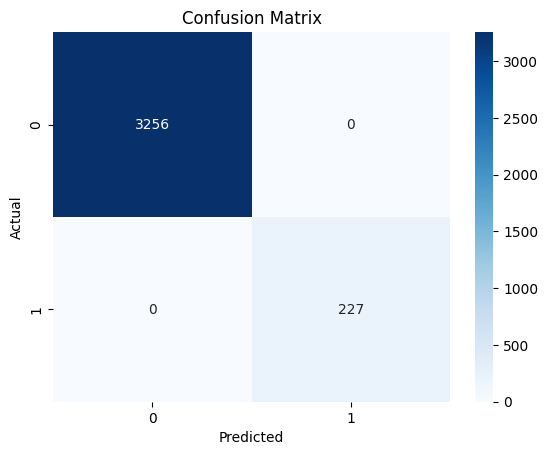

In [28]:
# Prediksi
y_pred = model.predict(X_test)

# Akurasi, F1-Score, Precision, Recall
print('Hasil Metrik Evaluasi')
print('----------------------')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')

# Classification Report
print('\n')
print('Classification Report')
print('-----------------------')
print(classification_report(y_test, y_pred))

# Confusion Matrix
print('\n')
print('Confusion Matrix')
print('-----------------------')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.get_feature_importance()})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
                   Feature  Importance
13        promotion_score   97.348900
8       length_of_service    1.611569
10             awards_won    0.961698
5         no_of_trainings    0.077833
0              department    0.000000
1                  region    0.000000
2               education    0.000000
3                  gender    0.000000
4     recruitment_channel    0.000000
6                     age    0.000000
7    previous_year_rating    0.000000
9   KPIs_met_more_than_80    0.000000
11     avg_training_score    0.000000
12      training_category    0.000000


In [30]:
# save model
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Testing

In [31]:
# baca model
with open('trained_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [32]:
data.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met_more_than_80', 'awards_won', 'avg_training_score',
       'training_category', 'promotion_score', 'is_promoted'],
      dtype='object')

In [33]:
# Karyawan testing
new_employee = pd.DataFrame({
    'department': ['Analytics'],
    'region': ['region_2'],
    'education': ["Bachelors"],
    'gender': ['f'],
    'recruitment_channel': ['other'],
    'no_of_trainings': [2],
    'age': [32],
    'previous_year_rating': [4.0],
    'length_of_service': [5],
    'KPIs_met_more_than_80': [1],
    'awards_won': [0],
    'avg_training_score': [87]
})

In [34]:
def preprocessing(new_employee):
    # Hitung promotion score
    new_employee['promotion_score'] = new_employee.apply(promotionScore, axis=1)

    # Kategorikan training
    new_employee['training_category'] = np.where(
        new_employee['no_of_trainings'] == 1, 'Basic',
        np.where(
            new_employee['no_of_trainings'].isin([2,3]), 'Intermediate',
            np.where(
                new_employee['no_of_trainings'].isin([4,5]), 'Advanced',
                'Expert'
            )
        )
    ).astype(str)  

    # Apa saja yang menjadi kolom kategori
    categorical_features = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'training_category']

    for col in categorical_features:
            new_employee[col] = new_employee[col].astype(str)
    return new_employee

def predict_promotion(new_employee, model):
    eval_pool = Pool(
        data=new_employee,
        cat_features=categorical_features,
        feature_names=list(new_employee.columns)
    )
    # 4. Lakukan prediksi
    prediction = model.predict(eval_pool)[0]
    probability = model.predict_proba(eval_pool)[0]
    
    return prediction, probability

In [37]:
preprocessing(new_employee)
prediction, probability = predict_promotion(new_employee, model)

print("\n=== Hasil Prediksi ===")
print(f"Prediction (0=Tidak Promosi, 1=Promosi): {prediction}")
print(f"Probability [Tidak Promosi, Promosi]: {probability}")

if prediction == 1:
    print("\nKaryawan ini dapat DIPROMOSIKAN")
    print(f"Tingkat keyakinan: {probability[1]*100:.1f}%")
else:
    print("\nKaryawan ini TIDAK untuk dipromosikan")
    print(f"Tingkat keyakinan: {probability[0]*100:.1f}%")

print("\nDetail Karyawan:")
print('-----------------------')
print(new_employee.transpose())


=== Hasil Prediksi ===
Prediction (0=Tidak Promosi, 1=Promosi): 1
Probability [Tidak Promosi, Promosi]: [0.41735114 0.58264886]

Karyawan ini dapat DIPROMOSIKAN
Tingkat keyakinan: 58.3%

Detail Karyawan:
-----------------------
                                  0
department                Analytics
region                     region_2
education                 Bachelors
gender                            f
recruitment_channel           other
no_of_trainings                   2
age                              32
previous_year_rating            4.0
length_of_service                 5
KPIs_met_more_than_80             1
awards_won                        0
avg_training_score               87
promotion_score                 8.0
training_category      Intermediate
